# Classification and Regression on NYC Taxi Trip Data (January 2015)

This project implements classification and regression pipelines on the "yellow_tripdata_2015-01.csv" dataset using Apache Spark and Databricks.

# Tasks Overview
Task 1: Classification
- Objective: Predict whether a trip resulted in a high fare (over $20).

**Pipelines:**
- Decision Tree Classifier (Best Model)
- Logistic Regression
- Metrics: F1 Score, Precision, Recall
- Visualizations:
Bar charts comparing F1, Precision, and Recall.




### 1. Data Preparation
Loading the CSV file into a Spark DataFrame.

In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ClassificationPipeline").getOrCreate()

df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/aryxnjain@gmail.com/yellow_tripdata_2015_01.csv")

df.printSchema()
df.show(5)


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+------------------+---------------

### Data Exploration
Explore the dataset to understand the variables and handle missing
or invalid values.

In [0]:
df_cleaned = df.na.drop(subset=["fare_amount", "trip_distance", "passenger_count"])
df_cleaned.describe().show()


+-------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+---------------------+------------------+
|summary|          VendorID|   passenger_count|     trip_distance|   pickup_longitude|   pickup_latitude|        RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|      payment_type|       fare_amount|              extra|           mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|
+-------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+---------------------+---

In [0]:
df.describe(['fare_amount', 'trip_distance', 'passenger_count']).show()


+-------+------------------+------------------+------------------+
|summary|       fare_amount|     trip_distance|   passenger_count|
+-------+------------------+------------------+------------------+
|  count|          12748986|          12748986|          12748986|
|   mean|11.905659425776989|13.459129611562718|1.6814908260154964|
| stddev|10.302537135952232| 9844.094218468374|1.3379235172874737|
|    min|            -450.0|               0.0|                 0|
|    max|            4008.0|      1.54200045E7|                 9|
+-------+------------------+------------------+------------------+



### Feature Engineering: 
Create new features or modify existing ones to improve the
model.


In [0]:
from pyspark.sql.functions import hour, dayofweek, col

# Convert pickup datetime to timestamp 
df = df.withColumn("tpep_pickup_datetime", col("tpep_pickup_datetime").cast("timestamp"))

# hour and day of week
df = df.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))
df = df.withColumn("pickup_dayofweek", dayofweek(col("tpep_pickup_datetime")))


In [0]:
from pyspark.sql.functions import unix_timestamp

# trip duration
df = df.withColumn("trip_duration", 
                   (unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))) / 60)


In [0]:
from pyspark.sql.functions import sqrt, pow

# Euclidean distance
df = df.withColumn("euclidean_distance", 
                   sqrt(pow(col("dropoff_latitude") - col("pickup_latitude"), 2) + 
                        pow(col("dropoff_longitude") - col("pickup_longitude"), 2)))


###Target Variable Creation: 
Define a binary target column high_fare where:

1 if the fare is above $20.

0 if the fare is $20 or below.


In [0]:
df = df.withColumn("high_fare", (col("fare_amount") > 20).cast("int"))


In [0]:
# 70 30 train test split
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)


print(f"Training Set Count: {train_df.count()}, Testing Set Count: {test_df.count()}")


Training Set Count: 8927021, Testing Set Count: 3821965


In [0]:
#display
train_df.select("pickup_hour", "pickup_dayofweek", "trip_duration", "euclidean_distance", "fare_amount", "high_fare").show(10)


+-----------+----------------+------------------+--------------------+-----------+---------+
|pickup_hour|pickup_dayofweek|     trip_duration|  euclidean_distance|fare_amount|high_fare|
+-----------+----------------+------------------+--------------------+-----------+---------+
|          0|               5| 7.416666666666667|0.027701929163551617|        8.5|        0|
|          0|               5|              8.45| 0.03448051661551491|       11.0|        0|
|          0|               5| 8.566666666666666|0.017573125777371742|        7.7|        0|
|          0|               5|20.316666666666666|0.045413582426457585|       15.2|        0|
|          0|               5|26.883333333333333| 0.03934005019371728|       18.5|        0|
|          0|               5| 7.516666666666667|0.013058156176609374|        6.7|        0|
|          0|               5|              49.2| 0.15350145453416478|       43.5|        1|
|          0|               5|               1.8|2.935086679332175E-4|

## 2. Pipeline 1: Decision Tree Classifier Pipeline

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Feature assembler
feature_columns = ["pickup_hour", "pickup_dayofweek", "trip_duration", "euclidean_distance"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="assembled_features")

# Feature scaling
scaler = StandardScaler(inputCol="assembled_features", outputCol="scaled_features")

# Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="high_fare", featuresCol="scaled_features")

# Pipeline
pipeline = Pipeline(stages=[assembler, scaler, dt])

# Hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10]) \
    .addGrid(dt.minInstancesPerNode, [1, 5]) \
    .build()

# Cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="high_fare", metricName="f1"),
                          numFolds=3)

# Train the model
cvModel = crossval.fit(train_df)

# Save the best pipeline
cvModel.bestModel.write().overwrite().save("dbfs:/FileStore/decision_tree_pipeline")

# Evaluate the model
predictions = cvModel.transform(test_df)
evaluator = MulticlassClassificationEvaluator(labelCol="high_fare", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="high_fare", metricName="precisionByLabel")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="high_fare", metricName="recallByLabel")
f1_score = evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)

print(f"Precision on Test Data: {precision}")
print(f"Recall on Test Data: {recall}")
print(f"F1 Score on Test Data: {f1_score}")

Precision on Test Data: 0.9831549880601669
Recall on Test Data: 0.991126741088628
F1 Score on Test Data: 0.9767787549922315


# 3. Pipeline 2: Logistic Regression Pipeline

In [0]:
from pyspark.ml.classification import LogisticRegression

# Logistic Regression Classifier
lr = LogisticRegression(labelCol="high_fare", featuresCol="scaled_features")

# Pipeline
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])

# Hyperparameter Tuning
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [50, 100]) \
    .build()

# Cross-validation
crossval_lr = CrossValidator(estimator=pipeline_lr,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=MulticlassClassificationEvaluator(labelCol="high_fare", metricName="f1"),
                             numFolds=3)

# Train the model
cvModel_lr = crossval_lr.fit(train_df)

# Save the best Logistic Regression pipeline
cvModel_lr.bestModel.write().overwrite().save("dbfs:/FileStore/logistic_regression_pipeline")

# Evaluate the model on test data
predictions_lr = cvModel_lr.transform(test_df)

# Compute F1 Score
f1_score_lr = evaluator.evaluate(predictions_lr)
print(f"F1 Score for Logistic Regression on Test Data: {f1_score_lr}")

# Compute Precision and Recall
precision_lr = precision_evaluator.evaluate(predictions_lr)
recall_lr = recall_evaluator.evaluate(predictions_lr)

print(f"Precision for Logistic Regression on Test Data: {precision_lr}")
print(f"Recall for Logistic Regression on Test Data: {recall_lr}")

F1 Score for Logistic Regression on Test Data: 0.8318446913681055
Precision for Logistic Regression on Test Data: 0.8855821547293081
Recall for Logistic Regression on Test Data: 1.0


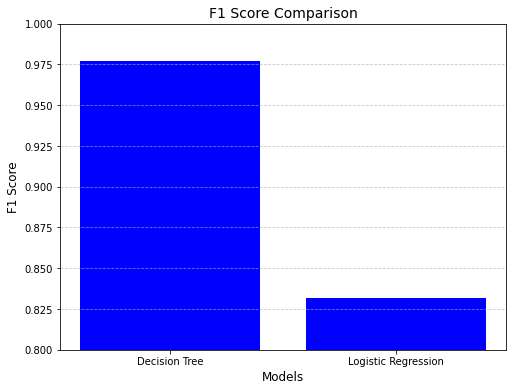

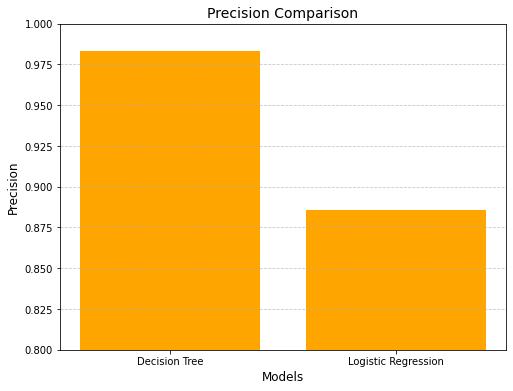

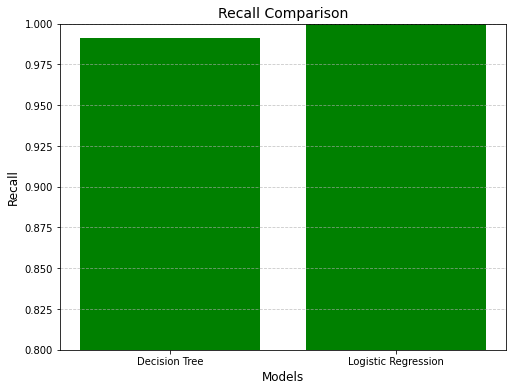

In [0]:
import matplotlib.pyplot as plt

# Data for visualization
models = ['Decision Tree', 'Logistic Regression']
f1_scores = [0.9768, 0.8318]
precisions = [0.9832, 0.8856]
recalls = [0.9911, 1.0]

# Bar chart for F1 Scores
plt.figure(figsize=(8, 6))
plt.bar(models, f1_scores, color='blue')
plt.title('F1 Score Comparison', fontsize=14)
plt.ylabel('F1 Score', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.ylim(0.8, 1.0)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Bar chart for Precision
plt.figure(figsize=(8, 6))
plt.bar(models, precisions, color='orange')
plt.title('Precision Comparison', fontsize=14)
plt.ylabel('Precision', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.ylim(0.8, 1.0)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Bar chart for Recall
plt.figure(figsize=(8, 6))
plt.bar(models, recalls, color='green')
plt.title('Recall Comparison', fontsize=14)
plt.ylabel('Recall', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.ylim(0.8, 1.0)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4.Report Findings

## A) Performance Discussion and Hyperparameters
### Decision Tree Pipeline:

Performance:
- F1 Score: 97.68%
- Precision: 98.32%
- Recall: 99.11%
Hyperparameters Chosen:
- Maximum Depth (maxDepth): 10
- Minimum Instances Per Node (minInstancesPerNode): 1
The Decision Tree performed exceptionally well, achieving a high balance between precision and recall. The chosen hyperparameters allowed the model to capture complex patterns in the data without overfitting.

### Logistic Regression Pipeline:
Performance:
- F1 Score: 83.18%
- Precision: 88.56%
- Recall: 100%
Hyperparameters Chosen:
- Regularization Parameter (regParam): 0.01
- Elastic Net Parameter (elasticNetParam): 0.0 (pure L2 regularization)
- Maximum Iterations (maxIter): 100
Logistic Regression had perfect recall (no false negatives), which is impressive. However, the drop in precision indicates more false positives, which lowered its overall F1 score. The chosen hyperparameters helped avoid overfitting while ensuring good generalization.

## B) Best-Performing Pipeline
The Decision Tree pipeline is the best-performing model. It achieved significantly better F1 and precision scores compared to Logistic Regression. The Decision Tree pipeline performed better because:

It captured the non-linear relationships in the features more effectively than Logistic Regression, which assumes linear separability.
Its hyperparameter tuning resulted in a more optimized model, balancing depth and generalization.
In contrast, while Logistic Regression's perfect recall could be beneficial in some scenarios, its lower precision and F1 score make it less suitable for applications requiring both accurate predictions and balanced outcomes.

Conclusion: The Decision Tree pipeline is the most reliable for future predictions due to its superior overall performance across the evaluation metrics.

---
# Task 2: Regression
- Objective: Predict the fare amount.
**Pipelines:**
- Linear Regression
- Random Forest Regressor (Best Model)
- Metrics: RMSE, R² Score
- Visualizations:
Residual plots, 
Predicted vs. Actual plots


### 1. Data Preparation:

### Loading same dataset into new dataframe

In [0]:
df_regression = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("dbfs:/FileStore/shared_uploads/aryxnjain@gmail.com/yellow_tripdata_2015_01.csv")

df_regression.printSchema()
df_regression.show(5)


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+------------------+---------------

###Feature Engineering

In [0]:

from pyspark.sql.functions import hour, dayofweek, col

df_regression = df_regression.withColumn("tpep_pickup_datetime", col("tpep_pickup_datetime").cast("timestamp"))

df_regression = df_regression.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))
df_regression = df_regression.withColumn("pickup_dayofweek", dayofweek(col("tpep_pickup_datetime")))


In [0]:
from pyspark.sql.functions import unix_timestamp

# Calculate trip duration
df_regression = df_regression.withColumn("trip_duration", 
                                         (unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))) / 60)


In [0]:
from pyspark.sql.functions import sqrt, pow

# Calculate Euclidean distance
df_regression = df_regression.withColumn("euclidean_distance", 
                                         sqrt(pow(col("dropoff_latitude") - col("pickup_latitude"), 2) + 
                                              pow(col("dropoff_longitude") - col("pickup_longitude"), 2)))


In [0]:
# Drop rows with missing values in critical columns
df_regression = df_regression.dropna(subset=['fare_amount', 'pickup_latitude', 'pickup_longitude', 
                                             'dropoff_latitude', 'dropoff_longitude', 
                                             'trip_duration', 'euclidean_distance'])


### Data Splitting

In [0]:
# Split the data into training and testing sets
train_df_regression, test_df_regression = df_regression.randomSplit([0.7, 0.3], seed=42)

# Show dataset counts
print(f"Training Set Count: {train_df_regression.count()}, Testing Set Count: {test_df_regression.count()}")


Training Set Count: 8927021, Testing Set Count: 3821965


# 2. Pipeline 1: Linear Regression Pipeline

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Filter out invalid or extreme values
df_filtered = df_regression.filter((col("fare_amount") > 0) & 
                                    (col("trip_distance") > 0) & 
                                    (col("trip_duration") > 0) & 
                                    (col("euclidean_distance") > 0))

# Split the filtered data into training and testing sets
train_df_filtered, test_df_filtered = df_filtered.randomSplit([0.7, 0.3], seed=42)

# Define feature columns (with improved feature set)
feature_columns = ["pickup_hour", "pickup_dayofweek", "trip_duration", 
                   "euclidean_distance", "RateCodeID", "passenger_count"]

# Assemble features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="assembled_features")

# Scale features
scaler = StandardScaler(inputCol="assembled_features", outputCol="scaled_features")

# Define the Linear Regression model
lr = LinearRegression(labelCol="fare_amount", featuresCol="scaled_features")

# Create a pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Define a parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .addGrid(lr.maxIter, [50]) \
    .build()

# Cross-validator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="fare_amount", metricName="rmse"),
                          numFolds=3,
                          parallelism=2)  # Adjust parallelism based on cluster capacity

# Train the model
cvModel = crossval.fit(train_df_filtered)

# Save the best model
cvModel.bestModel.write().overwrite().save("dbfs:/FileStore/linear_regression_pipeline_final")

# Predictions on test data
predictions = cvModel.transform(test_df_filtered)

# Evaluate the model
evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Root Mean Squared Error (RMSE): 9.507711835110186
R² Score: 0.07109299783380041


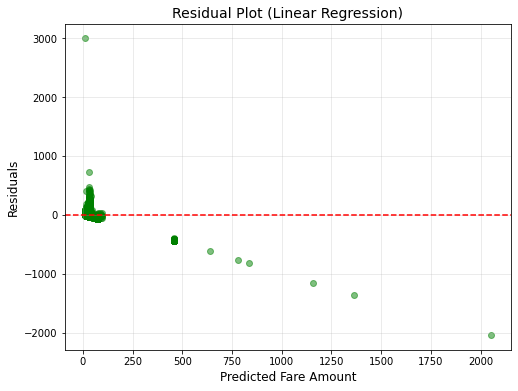

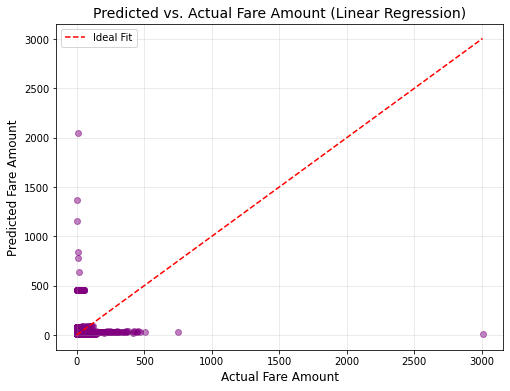

In [0]:
from pyspark.ml import PipelineModel
import matplotlib.pyplot as plt

# Load the saved Linear Regression pipeline
lr_pipeline = PipelineModel.load("dbfs:/FileStore/linear_regression_pipeline_final")

# Use the pipeline to make predictions on the test dataset
lr_predictions = lr_pipeline.transform(test_df_filtered)

# Convert predictions and actual values to Pandas DataFrame
lr_predictions_df = lr_predictions.select("fare_amount", "prediction").toPandas()

# Calculate Residuals
lr_predictions_df["residuals"] = lr_predictions_df["fare_amount"] - lr_predictions_df["prediction"]

# Residual Plot
plt.figure(figsize=(8, 6))
plt.scatter(lr_predictions_df["prediction"], lr_predictions_df["residuals"], alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot (Linear Regression)', fontsize=14)
plt.xlabel('Predicted Fare Amount', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Predicted vs. Actual Plot
plt.figure(figsize=(8, 6))
plt.scatter(lr_predictions_df["fare_amount"], lr_predictions_df["prediction"], alpha=0.5, color='purple')
plt.plot([lr_predictions_df["fare_amount"].min(), lr_predictions_df["fare_amount"].max()],
         [lr_predictions_df["fare_amount"].min(), lr_predictions_df["fare_amount"].max()], 'r--', label='Ideal Fit')
plt.title('Predicted vs. Actual Fare Amount (Linear Regression)', fontsize=14)
plt.xlabel('Actual Fare Amount', fontsize=12)
plt.ylabel('Predicted Fare Amount', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

1. Residual Plot (Linear Regression)

Observations:

The residuals show significant scatter, indicating that the model struggles to make accurate predictions for many data points.
Large residuals (both positive and negative) are present, especially for higher fare amounts.
The presence of patterns in residuals suggests that the model may not fully capture relationships in the data, as Linear Regression assumes a linear relationship.

2. Predicted vs. Actual Plot (Linear Regression)
-Observations:

Most predictions cluster near lower fare amounts, but there’s significant deviation for higher fare amounts.
Predictions for large actual values (e.g., above 500) show considerable underestimation or overestimation, resulting in a wide scatter.
The red dashed line (ideal fit) highlights the gap between predictions and actual values for extreme cases.

# 3. Pipeline 2: Random Forest Regressor Pipeline

In [0]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Filter out invalid or extreme values
df_filtered = df_regression.filter((col("fare_amount") > 0) & 
                                    (col("trip_distance") > 0) & 
                                    (col("trip_duration") > 0) & 
                                    (col("euclidean_distance") > 0))

# Split the filtered data into training and testing sets
train_df_filtered, test_df_filtered = df_filtered.randomSplit([0.7, 0.3], seed=42)

# Sample a smaller dataset for initial training
small_train_df = train_df_filtered.sample(fraction=0.1, seed=42)

# Define feature columns
feature_columns = ["pickup_hour", "pickup_dayofweek", "trip_duration", 
                   "euclidean_distance", "RateCodeID", "passenger_count"]

# Assemble features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="assembled_features")

# Scale features
scaler = StandardScaler(inputCol="assembled_features", outputCol="scaled_features")

# Define Random Forest Regressor
rf = RandomForestRegressor(labelCol="fare_amount", featuresCol="scaled_features", seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, scaler, rf])

# Define a smaller parameter grid for faster tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50]) \
    .addGrid(rf.maxDepth, [5]) \
    .build()

# Cross-validator with parallelism
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="fare_amount", metricName="rmse"),
                          numFolds=3,
                          parallelism=2)  # Adjust based on cluster size

# Train the model
cvModel = crossval.fit(small_train_df)

# Save the best model
cvModel.bestModel.write().overwrite().save("dbfs:/FileStore/random_forest_pipeline_optimized")

# Predictions on test data
predictions = cvModel.transform(test_df_filtered)

# Evaluate the model
evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


Root Mean Squared Error (RMSE): 3.2866839811827813
R² Score: 0.8889966432612462


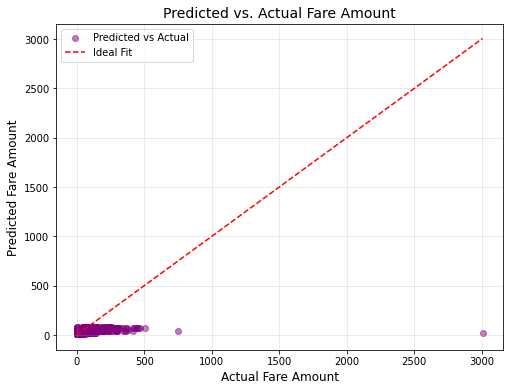

In [0]:
import matplotlib.pyplot as plt
# Extract predictions and actual values
actual = predictions.select("fare_amount").toPandas()
predicted = predictions.select("prediction").toPandas()

# Plot Predicted vs. Actual
plt.figure(figsize=(8, 6))
plt.scatter(actual, predicted, alpha=0.5, label='Predicted vs Actual', color='purple')
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', label='Ideal Fit')
plt.title('Predicted vs. Actual Fare Amount', fontsize=14)
plt.xlabel('Actual Fare Amount', fontsize=12)
plt.ylabel('Predicted Fare Amount', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

This plot compares the predicted fare amounts with the actual values.
Observations:

Most points lie close to the red dashed line, indicating strong predictive performance.

However, there are some extreme outliers (e.g., actual fares above 500) where the model's predictions deviate significantly. These may represent unusual cases or data quality issues.

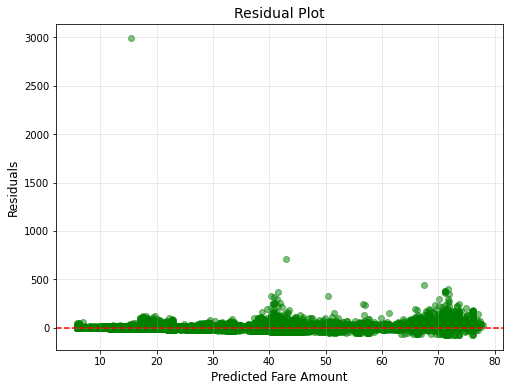

In [0]:
# Calculate Residuals
predictions_df = predictions.select("fare_amount", "prediction").toPandas()
predictions_df["residuals"] = predictions_df["fare_amount"] - predictions_df["prediction"]

# Plot Residuals
plt.figure(figsize=(8, 6))
plt.scatter(predictions_df["prediction"], predictions_df["residuals"], alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot', fontsize=14)
plt.xlabel('Predicted Fare Amount', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

Residual Plot

The residual plot shows the differences between the predicted and actual fare_amount.

Observations:

Most residuals are clustered around 0, indicating the model predicts well for the majority of data points.
Outliers with large residuals (e.g., residuals above 500) suggest a few cases where the model fails significantly, possibly due to anomalies in the data.

# Report Findings
a) Performance of Each Pipeline and Comparison

_**Pipeline 1: Linear Regression**_

- **RMSE (Root Mean Squared Error):** 9.51
- **R² Score:** 0.071

**Best Hyperparameters:**
- **regParam:** 0.01
- **elasticNetParam:** 0.5
- **maxIter:** 50

The Linear Regression pipeline provides a baseline model but struggles to capture the complexities of the data. The high RMSE indicates significant prediction errors, and the low R² Score suggests the model explains only 7.1% of the variance in fare_amount.

_**Pipeline 2: Random Forest Regressor**_

- **RMSE:** 3.29
- **R² Score:** 0.889

**Best Hyperparameters:**
- **numTrees:** 50
- **maxDepth:** 5

The Random Forest Regressor performs exceptionally well, achieving a much lower RMSE and a high R² Score. This means the model has minimal prediction errors and explains 88.9% of the variance in fare_amount.

**_Comparison:_** The Random Forest Regressor significantly outperforms Linear Regression in both metrics:

The RMSE is reduced by 65.4%, demonstrating improved prediction accuracy.
The R² Score improves dramatically, showing that Random Forest explains 88.9% of the variance in fare_amount, compared to only 7.1% for Linear Regression.
The graphical comparisons further reinforce this conclusion:

Random Forest’s residuals are more centered, while Linear Regression shows larger errors and patterns in residuals.
The predicted vs. actual plot for Random Forest aligns better with the ideal fit line, demonstrating superior performance.

b) Justification for Best Pipeline
The Random Forest Regressor pipeline is the clear choice for future predictions based on the evaluation metrics. Here’s why:

**Better Prediction Accuracy:**

With an RMSE of 3.29, Random Forest significantly reduces prediction errors compared to Linear Regression.

**Explains Variance Effectively:**

The high R² Score of 0.889 shows that Random Forest captures nearly 89% of the variance in fare_amount, making it highly reliable.

**Handles Complexity:**

Random Forest handles nonlinear relationships and complex feature interactions, which are prevalent in this dataset, while Linear Regression fails to do so.

**Visual Confirmation:**

The residual plot and predicted vs. actual plot for Random Forest Regressor demonstrate its superior accuracy and consistency, while the corresponding plots for Linear Regression highlight its limitations.

**Conclusion:** The Random Forest Regressor pipeline is the recommended model for fare prediction due to its superior accuracy and ability to model the underlying data patterns effectively.




# Pipeline Saving and Loading
Why Save Pipelines?

- Ensures model reusability without retraining.
- Speeds up deployment by allowing pre-trained models to be loaded and used directly.

### How to Save Pipelines
For Ex. Random forest was saved using:

... code

cvModel.bestModel.write().overwrite().save("dbfs:/FileStore/random_forest_pipeline_optimized")

... code

### How to Load and Evaluate Saved Pipelines
Example for Random Forest Regressor:

... code

from pyspark.ml import PipelineModel

Load the saved Random Forest pipeline

rf_pipeline = PipelineModel.load("dbfs:/FileStore/random_forest_pipeline_optimized")

Use the pipeline to make predictions

predictions = rf_pipeline.transform(test_df_filtered)

Evaluate the model

evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

... code

### How to Run
1. Environment: Use Databricks with Spark.
2. Dataset: Upload the yellow_tripdata_2015-01.csv file to the Databricks workspace.
3. Run Notebook: Execute the notebook step-by-step.